## 1. Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports
require('flexplot')
require('tidyverse')
library(ggrepel)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: flexplot
Loading required package: tidyverse
In addition: Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  there is no package called ‘flexplot’


## 2. Load multivariable file

In [4]:
%%R -o df
df <- read_csv('processed_data/2023_subway_censusvar_multire.csv')

Rows: 18208 Columns: 52
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (27): Common Name, Equipment Description, Executive Comment, outage_cod...
dbl  (21): GEOID, Outage, Station MRN, Station ID, Complex ID, lat, long, AD...
dttm  (4): Out of Service Date, Estimated Return to Service Date, Actual Ret...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## 3. Understanding the data / Basic analysis

In [5]:
# missing values to be dealt with
df['maintenance_time'].isna().value_counts()

maintenance_time
False    15164
True      3044
Name: count, dtype: int64

In [6]:
# maintenance_time summary stat
df['maintenance_time'].describe()

count    15164.000000
mean         7.394358
std         55.056658
min          0.000000
25%          1.566667
50%          3.433333
75%          5.000000
max       3211.600000
Name: maintenance_time, dtype: float64

In [7]:
# categorize outage_codes into planned, unplanned, na, and unknown accoridng to the outage_code dictionary
planned = ['MSC','AP', 'PM', 'SOC', 'INS', 'CCR','CLN', 'MRP', 'REV']
unplanned = ['WRP', 'ACC','ENT', 'ENV','EUF','EWC', 'VNR', 'VRP', 'VAN', 'PNM', 'TAN', 'WD','WRK',
             'BRP', 'FIR','FNM', 'IRP', 'LTR', 'PNM', 'POW', 'TAN','WD', 'WRK']
na = ['CM', 'OPN', 'RCC', 'RTA', 'SCC', 'STA', 'UPO']

# create a new column 'planned' to categorize outage_code; if not in any of the lists, set to 'unknown'
df['planned'] = df['outage_code'].apply(lambda x: 'planned' if x in planned else ('unplanned' if x in unplanned else ('na' if x in na else 'unknown')))

df['planned'].value_counts()

In [9]:
# planned outage maintenance_time summary stat
df[df['planned']=='planned']['maintenance_time'].describe()

count    7044.000000
mean        4.528189
std         5.144456
min         0.000000
25%         3.000000
50%         4.583333
75%         5.150000
max       229.483333
Name: maintenance_time, dtype: float64

In [10]:
# unplanned outage maintenance_time summary stat
df[df['planned']=='unknown']['outage_code'].value_counts()

outage_code
FR     3549
UNI     774
TPE     591
APC     454
APT       6
Name: count, dtype: int64

In [ ]:
# top 10 station ID with the most unplanned outages

df[df['planned']=='unplanned']['Station ID'].value_counts().head(10)

In [12]:
#  top 10 station names with most unplanned maintenance
top_unplanned = list(df[df['planned']=='unplanned']['Station ID'].value_counts().head(10).index)

df[df['Station ID'].isin(top_unplanned)].groupby('Station ID')[['Stop Name', 'Borough']].first()

,Stop Name,Borough
Station ID,,
9.0,57 St-7 Av,M
106.0,Fulton St,M
161.0,59 St-Columbus Circle,M
221.0,21 St-Queensbridge,Q
223.0,Lexington Av/63 St,M
300.0,191 St,M
301.0,181 St,M
302.0,168 St-Washington Hts,M
402.0,Grand Central-42 St,M


## 4. Plot 1D charts

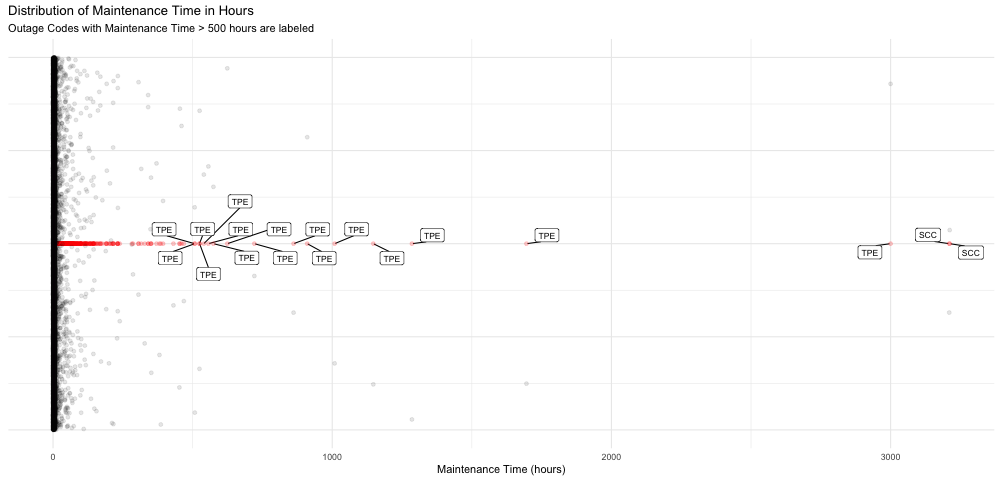

In [14]:
%%R -w 1000

df %>%
    filter(!is.na(maintenance_time)) %>%
    # filter(maintenance_time < 250) %>%
    ggplot() +
    aes(x = maintenance_time, y=1) +
    # for dots with maintenance_time > 1000 add text of their outage codes
    # increase max.overlaps to avoid overlapping text
    geom_label_repel(aes(label = ifelse(maintenance_time > 500, outage_code, '')), size = 3, box.padding = 0.5, max.overlaps=Inf) +
    geom_boxplot(color = 'red', alpha=.2) +
    geom_jitter(alpha = 0.1) +
    theme_minimal() +
    theme(axis.text.y = element_blank(), axis.title.y = element_blank()) +
    labs(title = 'Distribution of Maintenance Time in Hours', subtitle = 'Outage Codes with Maintenance Time > 500 hours are labeled', x = 'Maintenance Time (hours)') 

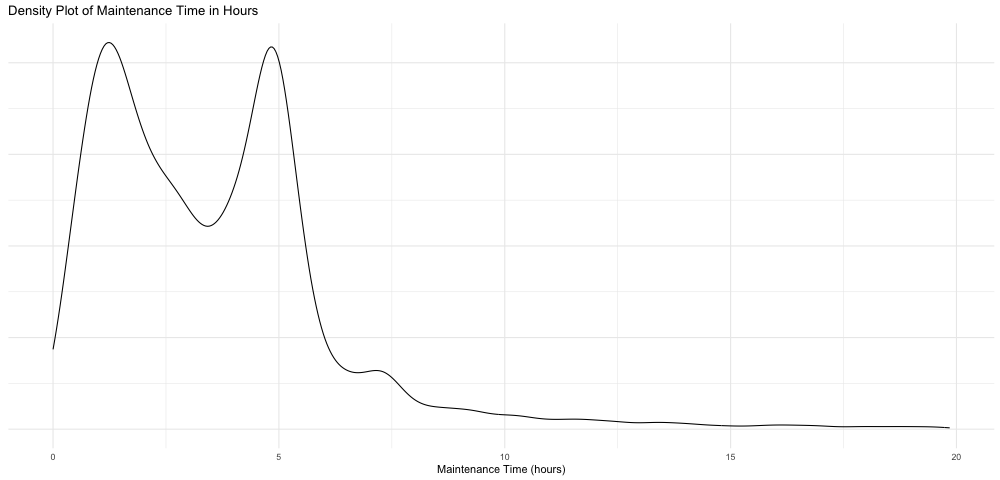

In [25]:
%%R -w 1000

df %>%
    filter(!is.na(maintenance_time)) %>%
    filter(maintenance_time < 20) %>%
    ggplot() +
    aes(x = maintenance_time) +
    geom_density() +
    theme_minimal() +
    # remove y ticks
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank()) +
    labs(title = 'Density Plot of Maintenance Time in Hours', x = 'Maintenance Time (hours)')

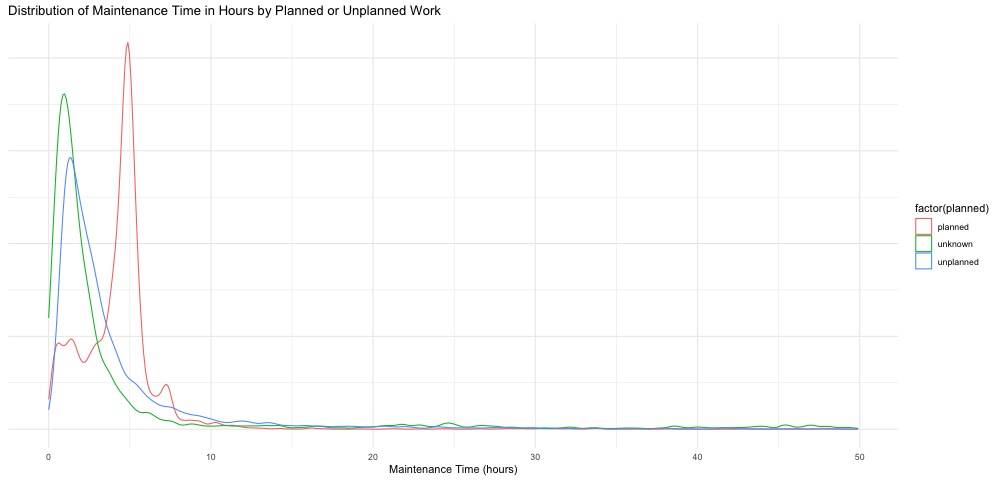

In [26]:
%%R -w 1000
df %>%
    filter(maintenance_time < 50) %>%
    filter(planned != 'na') %>%
    ggplot()+
    aes(x = maintenance_time, color = factor(planned)) +
    geom_density() +
    theme_minimal() +
    # remove y ticks
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(),axis.title.y=element_blank()) +
    labs(title = 'Distribution of Maintenance Time in Hours by Planned or Unplanned Work', x = 'Maintenance Time (hours)')

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Groups with fewer than two data points have been dropped. 

R[write to console]: 2: 
R[write to console]: In max(ids, na.rm = TRUE) :
R[write to console]: 
 
R[write to console]:  no non-missing arguments to max; returning -Inf



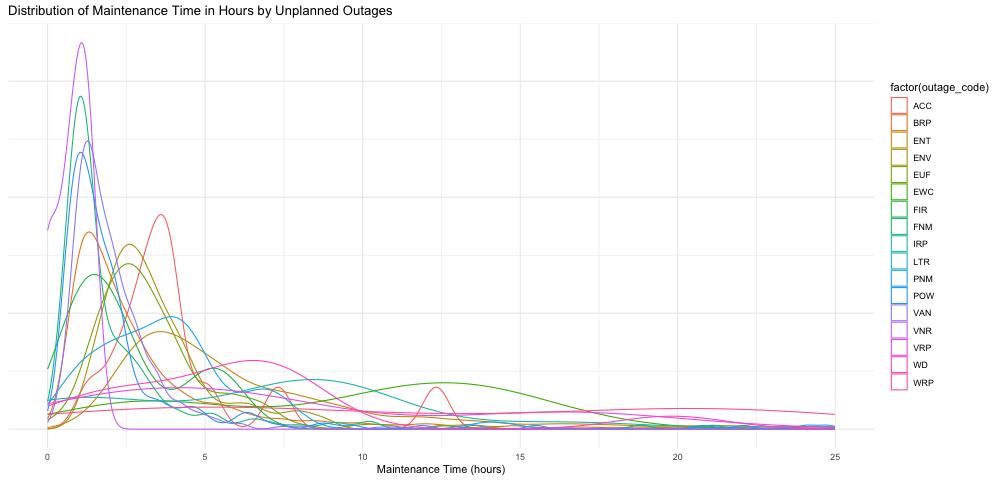

In [27]:
%%R -w 1000
df %>%
    filter(maintenance_time < 25) %>%
    filter(planned == 'unplanned') %>%
    ggplot()+
    aes(x = maintenance_time, color = factor(outage_code)) +
    geom_density() +
    theme_minimal() +
    # remove y ticks
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(),axis.title.y=element_blank()) +
    labs(title = 'Distribution of Maintenance Time in Hours by Unplanned Outages', x = 'Maintenance Time (hours)')

## 3. Multivariable regression 

In [18]:
%%R

model <- lm(maintenance_time ~ outage_code + med_earn_estimate + Structure + amb_pop_estimate + population_estimate, data = df)
model_summary <- summary(model)
model_summary


Call:
lm(formula = maintenance_time ~ outage_code + med_earn_estimate + 
    Structure + amb_pop_estimate + population_estimate, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-654.61   -2.75   -0.71    1.27 2934.83 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          6.653e+01  1.784e+01   3.729 0.000193 ***
outage_codeAP       -1.615e+00  1.498e+01  -0.108 0.914172    
outage_codeAPC       7.146e-01  1.501e+01   0.048 0.962040    
outage_codeAPT      -4.415e-01  2.733e+01  -0.016 0.987112    
outage_codeBRP       9.961e-01  1.485e+01   0.067 0.946506    
outage_codeCCR       2.267e+02  5.342e+01   4.244 2.21e-05 ***
outage_codeCLN       5.733e-01  1.604e+01   0.036 0.971484    
outage_codeENT       3.780e+00  1.495e+01   0.253 0.800346    
outage_codeENV      -1.597e-01  1.513e+01  -0.011 0.991579    
outage_codeEUF       2.725e-01  1.546e+01   0.018 0.985935    
outage_codeEWC       1.205e+01  2.019e+01   0.597 0.55076

In [19]:
%%R
# controlling for the type of outage
# outage type with the lowest p-value with maintenance_time
# data points 591

df2 <- df %>%
    filter(outage_code == 'TPE') 
model <- lm(maintenance_time ~ sub_pop_estimate + med_earn_estimate + Structure + amb_pop_estimate, data = df2)
model_summary <- summary(model)
model_summary


Call:
lm(formula = maintenance_time ~ sub_pop_estimate + med_earn_estimate + 
    Structure + amb_pop_estimate, data = df2)

Residuals:
    Min      1Q  Median      3Q     Max 
-162.47  -43.96  -37.06   -5.32 2916.91 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.498e+02  6.977e+01   3.580 0.000372 ***
sub_pop_estimate   1.200e-02  2.943e-02   0.408 0.683650    
med_earn_estimate -6.719e-04  1.721e-04  -3.904 0.000106 ***
StructureElevated -7.016e+01  7.447e+01  -0.942 0.346502    
StructureSubway   -9.375e+01  6.242e+01  -1.502 0.133677    
amb_pop_estimate  -3.978e-04  9.881e-03  -0.040 0.967903    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 186.9 on 583 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.04136,	Adjusted R-squared:  0.03314 
F-statistic:  5.03 on 5 and 583 DF,  p-value: 0.0001601



In [20]:
%%R
# look at range/summary stat of maintenance_time for outage_code TPE
df %>%
    filter(outage_code == 'TPE') %>%
    # plot scatter plot of maintenance_time vs med_earn_estimate
    select(maintenance_time) %>%
    summary()

 maintenance_time   
 Min.   :   0.0833  
 1st Qu.:   3.2833  
 Median :  21.5833  
 Mean   :  66.2472  
 3rd Qu.:  50.1167  
 Max.   :2999.9167  
 NA's   :2          


In [21]:
%%R
# controlling for the type of outage
# most common outage type from 'unknown' category
# data points 3549

df %>%
    filter(outage_code == 'FR') %>%
    lm(maintenance_time ~ sub_pop_estimate + med_earn_estimate + Structure + amb_pop_estimate, data = .) %>%
    summary()



Call:
lm(formula = maintenance_time ~ sub_pop_estimate + med_earn_estimate + 
    Structure + amb_pop_estimate, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1715 -0.8689 -0.3375  0.5262 24.0800 

Coefficients:


                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.983e+00  1.664e-01  11.915   <2e-16 ***
sub_pop_estimate   3.018e-04  1.442e-04   2.093   0.0366 *  
med_earn_estimate -9.555e-07  8.639e-07  -1.106   0.2689    
StructureOpen Cut  2.709e-01  3.143e-01   0.862   0.3890    
StructureSubway   -1.957e-01  1.449e-01  -1.350   0.1772    
StructureViaduct   3.774e-01  3.824e-01   0.987   0.3240    
amb_pop_estimate  -7.467e-05  4.488e-05  -1.664   0.0965 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.518 on 1263 degrees of freedom
  (2279 observations deleted due to missingness)
Multiple R-squared:  0.008844,	Adjusted R-squared:  0.004136 
F-statistic: 1.878 on 6 and 1263 DF,  p-value: 0.08131



In [22]:
%%R
# controlling for the type of outage
# the most common from 'unplanned' category
# numbers of data points: 3277

df %>%
    filter(outage_code == 'BRP') %>%
    lm(maintenance_time ~ sub_pop_estimate + med_earn_estimate + Structure + amb_pop_estimate, data = .) %>%
    summary()


Call:
lm(formula = maintenance_time ~ sub_pop_estimate + med_earn_estimate + 
    Structure + amb_pop_estimate, data = .)

Residuals:
    Min      1Q  Median      3Q     Max 
 -4.771  -3.008  -2.170  -0.354 143.843 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        4.716e+00  4.992e-01   9.448   <2e-16 ***
sub_pop_estimate  -8.385e-04  5.376e-04  -1.560   0.1189    
med_earn_estimate -3.969e-06  3.018e-06  -1.315   0.1885    
StructureOpen Cut -1.537e+00  8.811e-01  -1.744   0.0813 .  
StructureSubway   -2.672e-01  4.564e-01  -0.586   0.5582    
StructureViaduct  -3.780e-03  1.548e+00  -0.002   0.9981    
amb_pop_estimate   3.038e-04  1.601e-04   1.897   0.0579 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.409 on 3188 degrees of freedom
  (82 observations deleted due to missingness)
Multiple R-squared:  0.003299,	Adjusted R-squared:  0.001423 
F-statistic: 1.759 on 6 and 3188 DF,  p-value